In [2]:
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

## load SOP

In [792]:
#read brands
file_path = '/Users/ankit/code/innovations_docs/auto_approve/lux_dataset/lux_sop_updated.xlsx'
sheet_name = 'Brand List'

# Read the Excel file
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Select specific rows and columns
sop_df = df[['Brand', 'OCR_VALUE', 'Code']]
sop_df
# Convert OCR_VALUE to an array of strings
sop_df["OCR_VALUE"] = sop_df["OCR_VALUE"].apply(lambda x: [x.replace('-','')])

# Convert Code to an array of strings, treating '/' as a delimiter
# sop_df["Code"] = sop_df["Code"].apply(lambda x: x.split('/'))
sop_df["Code"] = sop_df["Code"].apply(lambda x: [part.strip() for part in x.split("/")])#remove white spaces
sop_df

,Brand,OCR_VALUE,Code
0,Alain Mikli,[Alain Mikli],[AO]
1,Armani Exchange,[Armani Exchange],[AX]
2,Burberry,[Burberry],[BE]
3,Chanel,[Chanel],[CH]
4,Coach,[Coach],[HC]
5,Dolce & Gabbana,[Dolce & Gabbana],[DG]
6,Emporio Armani,[Emporio Armani],[EA]
7,Giorgio Armani,[Giorgio Armani],"[AR, GA]"
8,Michael Kors,[Michael Kors],[MK]
9,Miu Miu,[Miu Miu],[MU]


In [603]:
import re
def split_string(s):
        match = re.match(r"([a-zA-Z]+)(\d+)(.*)", s)
        if match:
            # Combine the second and third groups
            combined = match.group(2) + match.group(3)
            return [match.group(1), combined]
        else:
            return None
        
def find_row_by_code(df, text):
    split_result = split_string(text)

    if split_result:
        extracted_code = split_result[0].upper()
        matching_row = df[df["Code"].apply(lambda x: extracted_code in x)]
        if not matching_row.empty:
            return {
                "OCR_VALUE": matching_row["OCR_VALUE"].values.tolist()[0],
                "Code": matching_row["Code"].values.tolist()[0]
            }
        else:
            return {"OCR_VALUE": [], "Code": []}
    else:
        return {"OCR_VALUE": [], "Code": []}
    
input_string = "rb3663"
splits = split_string(input_string)
print(f'<<<< split_string = {splits}')
result = find_row_by_code(sop_df, input_string)
print(result)

<<<< split_string = ['rb', '3663']
{'OCR_VALUE': ['RayBan'], 'Code': ['RB', 'RX', 'RY', 'RJ', 'RW']}


## load data

In [5]:
test_data_df = pd.read_csv('lux_receipts.csv')
test_data_df['brand'] = test_data_df['brand'].str.replace(r' - Optical| - Sunglasses', '', regex=True)
test_data_df.head(3)

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1


## download images

In [6]:
# Base URL for images
base_url = 'https://cerrapoints.my/media/'

# Folder to save downloaded images
download_folder = 'dryice_test'
os.makedirs(download_folder, exist_ok=True)

In [79]:
# Get the top 5 rows
df_top5 = test_data_df.head(5)

# Loop through each row and download the image
for index, row in df_top5.iterrows():
    img_path = row['img']
    img_url = base_url + img_path
    img_name = os.path.basename(img_path)
    img_save_path = os.path.join(download_folder,'images', img_name)
    
    # Check if the image is already downloaded
    if os.path.exists(img_save_path):
        print(f'{index} - {img_name} already downloaded.')
    else:
        # Download and save the image
        try:
            response = requests.get(img_url, stream=True)
            response.raise_for_status()  # Check if the request was successful
            
            with open(img_save_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            
            print(f'{index} - Downloaded {img_name} to {img_save_path}')
        except requests.RequestException as e:
            print(f'{index} - Failed to download {img_name}. Error: {e}')


0 - mmexport1725432543089.png already downloaded.
1 - jpeg_20240904_144621.jpg already downloaded.
2 - jpeg_20240904_144549.jpg already downloaded.
3 - jpeg_20240904_144505.jpg already downloaded.
4 - mmexport1725431557988.png already downloaded.


## Prepare dataset

In [786]:
cleaned_approved_csv = 'clean_approved.csv'

In [787]:
# check all unique values of brands
unique_brands = test_data_df['brand'].unique()
unique_brands

array(['Armani Exchange', 'Coach', 'Oakley', 'Ray-Ban', 'Michael Kors',
       'Versace', 'Burberry', 'Emporio Armani', 'Prada',
       'Prada Linea Rossa', 'Tiffany & Co.', 'Miu Miu', 'Giorgio Armani',
       'Chanel', 'Swarovski', 'Vogue Eyewear', 'Oliver Peoples',
       'Polo Ralph Lauren', 'Dolce & Gabbana', 'Scuderia Ferrari'],
      dtype=object)

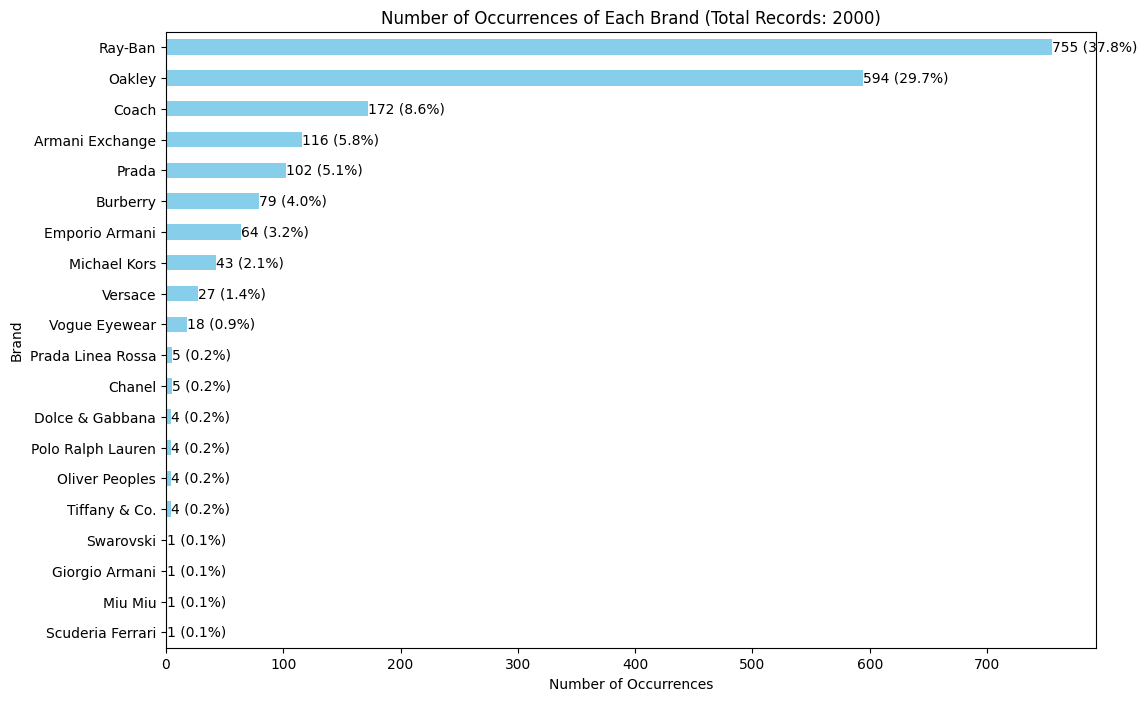

In [788]:
# graphical representation of records against each brand
# Count occurrences of each brand
brand_counts = test_data_df['brand'].value_counts()

# Calculate the total number of records
total_records = len(test_data_df)

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = brand_counts.plot(kind='barh', color='skyblue')

# Annotate the bars with the count and percentage values
for bar in bars.patches:
    width = bar.get_width()
    percentage = (width / total_records) * 100
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width)} ({percentage:.1f}%)', 
             va='center', ha='left', fontsize=10, color='black')

# Set the title with total number of records
plt.xlabel('Number of Occurrences')
plt.ylabel('Brand')
plt.title(f'Number of Occurrences of Each Brand (Total Records: {total_records})')
plt.gca().invert_yaxis()  # Optional: Invert y-axis to show the most frequent brand at the top
plt.show()

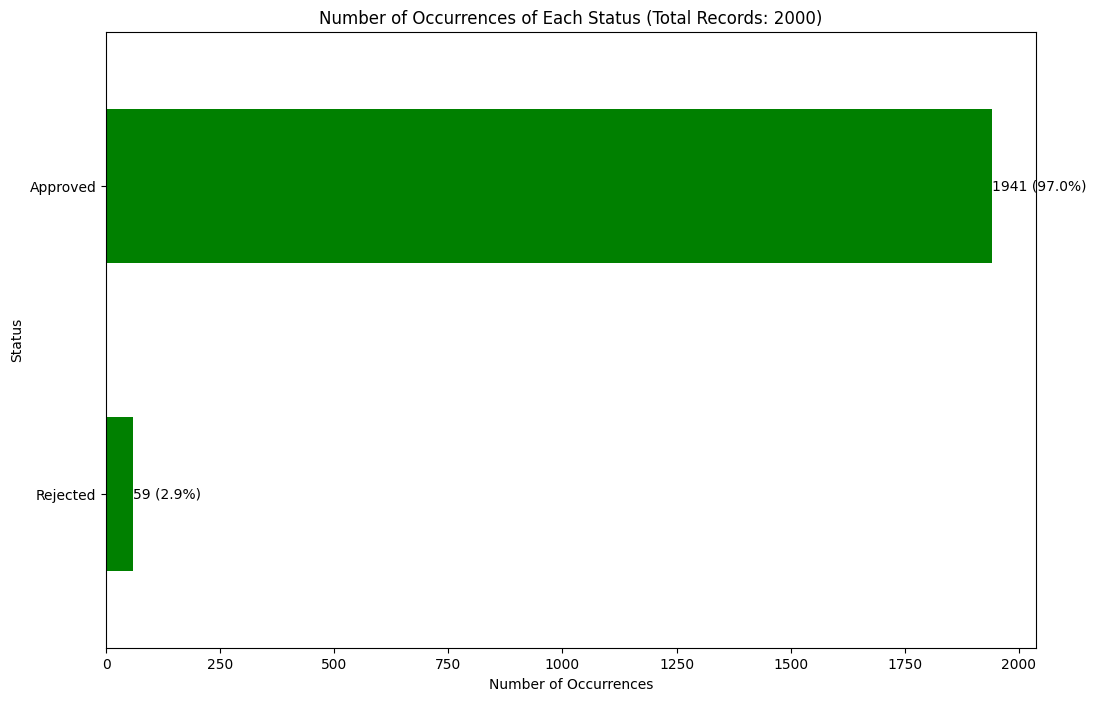

In [611]:
import matplotlib.pyplot as plt

# Map the status values to labels
status_labels = {1: 'Approved', 2: 'Rejected'}

# Create a new column with the mapped labels
test_data_df['status_label'] = test_data_df['status'].map(status_labels)

# Count occurrences of each status label
status_counts = test_data_df['status_label'].value_counts()

# Calculate the total number of records
total_records = len(test_data_df)

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = status_counts.plot(kind='barh', color='green')

# Annotate the bars with the count and percentage values
for bar in bars.patches:
    width = bar.get_width()  # The count value
    percentage = (width / total_records) * 100  # Calculate percentage
    plt.text(width, bar.get_y() + bar.get_height() / 2, 
             f'{int(width)} ({percentage:.1f}%)', 
             va='center', ha='left', fontsize=10, color='black')

# Set labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Status')
plt.title(f'Number of Occurrences of Each Status (Total Records: {total_records})')

# Optionally invert y-axis to show the most frequent status at the top
plt.gca().invert_yaxis()

# Display the plot
plt.show()


### run classifier to classify printed and hand-written receipt

In [612]:
image_size = (224, 224)
model = load_model('receipt_classifier_312.h5')

In [613]:
# test classifier on individual image

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):  # Adjust target_size as needed
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image to [0, 1]
    return img_array

# Function to make a prediction
def predict_receipt_type(img_path):
    try:
        img_array = preprocess_image(img_path)
        prediction = model.predict(img_array)
        class_index = int(prediction[0] > 0.5)  # Assuming binary classification with threshold 0.5
        class_labels = ['Handwritten', 'Printed']
        return class_labels[class_index], prediction[0][0]
    except Exception as e:
        return 'NA', str(e)


# Load and preprocess a new image
img_path = '/Users/ankit/code/learn/all_learnings/innovation POCs/auto_approve/dryice_test/images/zw9cx61fi8_TRCPONO.jpg'
receipt_type, confidence = predict_receipt_type(img_path)
print(f'Receipt Type: {receipt_type}, Confidence: {confidence}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Receipt Type: Printed, Confidence: 0.9995099306106567


/var/folders/2d/pvchbzgd1s7c2jy60p9lpbn00000gn/T/ipykernel_18563/2666671759.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(prediction[0] > 0.5)  # Assuming binary classification with threshold 0.5


In [614]:
# Add new columns for receipt type and classifier exceptions
test_data_df['receipt_type'] = ''
test_data_df['classifier_exception'] = ''

# Predict and update the DataFrame
for index, row in test_data_df.iterrows():
    img_path = os.path.join(download_folder, 'images', os.path.basename(row['img']))
    
    if os.path.exists(img_path):  # Check if image is downloaded
        receipt_type, exception = predict_receipt_type(img_path)
        if exception == 'NA':
            test_data_df.at[index, 'receipt_type'] = 'NA'
            test_data_df.at[index, 'classifier_exception'] = receipt_type
        else:
            test_data_df.at[index, 'receipt_type'] = receipt_type
            test_data_df.at[index, 'classifier_exception'] = ''
        print(f'index:{index} | Image: {img_path}, Receipt Type: {receipt_type}, Exception: {exception}')
    else:
        test_data_df.at[index, 'receipt_type'] = 'NA'
        test_data_df.at[index, 'classifier_exception'] = 'Image not found'
        print(f'Image not found: {img_path}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
index:0 | Image: dryice_test/images/mmexport1725432543089.png, Receipt Type: Printed, Exception: 0.9958375096321106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
index:1 | Image: dryice_test/images/jpeg_20240904_144621.jpg, Receipt Type: Printed, Exception: 0.9823927879333496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
index:2 | Image: dryice_test/images/jpeg_20240904_144549.jpg, Receipt Type: Printed, Exception: 0.9925058484077454
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
index:3 | Image: dryice_test/images/jpeg_20240904_144505.jpg, Receipt Type: Printed, Exception: 0.9997352957725525


/var/folders/2d/pvchbzgd1s7c2jy60p9lpbn00000gn/T/ipykernel_18563/2666671759.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(prediction[0] > 0.5)  # Assuming binary classification with threshold 0.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
index:4 | Image: dryice_test/images/mmexport1725431557988.png, Receipt Type: Printed, Exception: 0.9632272124290466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
index:5 | Image: dryice_test/images/mmexport1725431555379.png, Receipt Type: Printed, Exception: 0.9961987733840942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
index:6 | Image: dryice_test/images/mmexport1725431552114.png, Receipt Type: Printed, Exception: 0.9546573758125305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
index:7 | Image: dryice_test/images/mmexport1725424861537.png, Receipt Type: Printed, Exception: 0.9656163454055786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
index:8 | Image: dryice_test/images/mmexport1725424834562.png, Receipt Type: Printed, Exception: 0.9992997050285339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
index:9 | Image: dryice_test/images/uiy94s4bm4.jpg, Receipt Type: Printed, Exception: 0.8889703750610352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
index:10 | Image: dryice_test/images/mmexport1725

In [615]:
test_data_df

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1,Approved,Printed,,Yes,mmexport1725432543089.png,0.048774
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1,Approved,Printed,,Yes,jpeg_20240904_144621.jpg,0.265176
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1,Approved,Printed,,Yes,jpeg_20240904_144549.jpg,0.268750
3,961570,0.0,2024-09-04,Coach,104751,8371,Receipt/2024/jpeg_20240904_144505.jpg,1,Approved,Printed,,Yes,jpeg_20240904_144505.jpg,0.343383
4,961569,629.0,2024-08-31,Ray-Ban,OR004770,ORB2140F,Receipt/2024/mmexport1725431557988.png,1,Approved,Printed,,Yes,mmexport1725431557988.png,0.057045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,959556,0.0,2024-08-31,Coach,17907967,hc7133-94038d-57,Receipt/2024/kya4nbhaik.jpg,1,Approved,Printed,,Yes,kya4nbhaik.jpg,3.669875
1996,959555,0.0,2024-08-31,Ray-Ban,S115701105503,3825,Receipt/2024/jpeg_20240902_105739.jpg,1,Approved,Printed,,Yes,jpeg_20240902_105739.jpg,0.610140
1997,959554,0.0,2024-08-31,Ray-Ban,17907966,4391d-645087-56,Receipt/2024/cmahjoywpx.jpg,1,Approved,Printed,,Yes,cmahjoywpx.jpg,3.597690
1998,959553,0.0,2024-08-30,Coach,S115701105486,8395,Receipt/2024/jpeg_20240902_105620.jpg,1,Approved,Printed,,Yes,jpeg_20240902_105620.jpg,0.690908


In [616]:
# Filter out rows where receipt_type is 'NA'
filtered_df = test_data_df[test_data_df['receipt_type'] == 'Handwritten']
filtered_df

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB
93,961480,0.0,2024-08-15,Ray-Ban,21604305,4403F,Receipt/2024/jrjq2az5ys.jpg,1,Approved,Handwritten,,Yes,jrjq2az5ys.jpg,5.734918
171,961402,1300.0,2024-09-04,Ray-Ban,3255,RB7059,Receipt/2024/v38clk6uj7.jpg,1,Approved,Handwritten,,Yes,v38clk6uj7.jpg,0.577035
173,961400,500.0,2024-09-04,Ray-Ban,3254,RB4187,Receipt/2024/jyylzzc4tm.jpg,1,Approved,Handwritten,,Yes,jyylzzc4tm.jpg,0.476151
174,961399,700.0,2024-09-04,Ray-Ban,3253,RB3025,Receipt/2024/sew5y1l29c.jpg,1,Approved,Handwritten,,Yes,sew5y1l29c.jpg,0.562203
240,961331,0.0,2024-08-03,Ray-Ban,13932,5421 2012,Receipt/2024/jpeg_20240904_112623.jpg,1,Approved,Handwritten,,Yes,jpeg_20240904_112623.jpg,0.148948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,959612,479.0,2024-08-30,Oakley,S122101104132,SPOO9289,Receipt/2024/jpeg_20240902_121037_v9zYNHj.jpg,1,Approved,Handwritten,,Yes,jpeg_20240902_121037_v9zYNHj.jpg,0.334787
1940,959611,509.0,2024-08-30,Oakley,S122101104132,SPOO9284,Receipt/2024/jpeg_20240902_121037.jpg,1,Approved,Handwritten,,Yes,jpeg_20240902_121037.jpg,0.334787
1947,959604,464.0,2024-08-27,Ray-Ban,S122101104122,SP2140F,Receipt/2024/jpeg_20240902_120301_eRYKY9o.jpg,1,Approved,Handwritten,,Yes,jpeg_20240902_120301_eRYKY9o.jpg,0.335852
1950,959601,504.0,2024-08-27,Emporio Armani,S122101104122,SP2122D,Receipt/2024/jpeg_20240902_120301.jpg,1,Approved,Handwritten,,Yes,jpeg_20240902_120301.jpg,0.335852


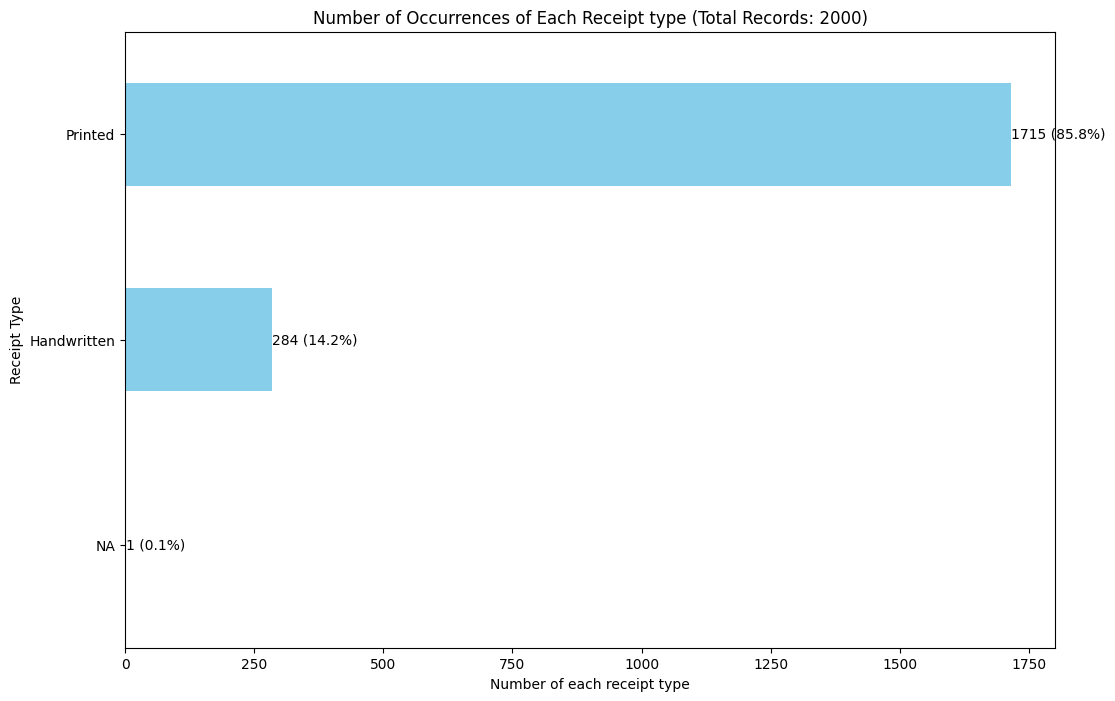

In [617]:

# Count occurrences of each receipt_type
receipt_type_counts = test_data_df['receipt_type'].value_counts()

# Calculate the total number of records
total_records = len(test_data_df)

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = receipt_type_counts.plot(kind='barh', color='skyblue')

# Annotate the bars with the count and percentage values
for bar in bars.patches:
    width = bar.get_width()
    percentage = (width / total_records) * 100
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width)} ({percentage:.1f}%)', 
             va='center', ha='left', fontsize=10, color='black')

# Set the title with total number of records
plt.xlabel('Number of each receipt type')
plt.ylabel('Receipt Type')
plt.title(f'Number of Occurrences of Each Receipt type (Total Records: {total_records})')
plt.gca().invert_yaxis()  # Optional: Invert y-axis to show the most frequent brand at the top
plt.show()


### data pre-processing

In [618]:

import os
import stat

updated_data_source = os.path.join(download_folder, 'csvs', 'updated_data.csv')
os.makedirs(os.path.dirname(updated_data_source), exist_ok=True)

file_exists = []
just_file_names = []
file_sizes = []
top_records =  test_data_df
for index, row in top_records.iterrows():
    print(f"<<<< row[img] = {row['img']}")
    file_path = row['img']
    file_name = os.path.basename(file_path)
    just_file_names.append(file_name)
    file_check = os.path.exists(os.path.join(download_folder, 'images', file_name))
    
    if file_check:
        file_exists.append('Yes')
        file_full_path= os.path.join(download_folder,'images', file_name)
        file_size_bytes = os.path.getsize(file_full_path)
        # Convert bytes to megabytes (1 MB = 1,000,000 bytes)
        file_size_mb = file_size_bytes / 1_000_000
        file_sizes.append(file_size_mb) 
    else:
        file_exists.append('No')
        file_sizes.append(0)  # If file doesn't exist, set size to 0.

top_records['file_exists'] = file_exists
top_records['file_name'] = just_file_names
top_records['file_size_MB'] = file_sizes
# Remove rows where file_exists is 'No'
top_records = top_records[top_records['file_exists'] != 'No']
top_records.to_csv(updated_data_source, index=False)
top_records

<<<< row[img] = Receipt/2024/mmexport1725432543089.png
<<<< row[img] = Receipt/2024/jpeg_20240904_144621.jpg
<<<< row[img] = Receipt/2024/jpeg_20240904_144549.jpg
<<<< row[img] = Receipt/2024/jpeg_20240904_144505.jpg
<<<< row[img] = Receipt/2024/mmexport1725431557988.png
<<<< row[img] = Receipt/2024/mmexport1725431555379.png
<<<< row[img] = Receipt/2024/mmexport1725431552114.png
<<<< row[img] = Receipt/2024/mmexport1725424861537.png
<<<< row[img] = Receipt/2024/mmexport1725424834562.png
<<<< row[img] = Receipt/2024/uiy94s4bm4.jpg
<<<< row[img] = Receipt/2024/mmexport1725424859066.png
<<<< row[img] = Receipt/2024/tdl4o42yra.jpg
<<<< row[img] = Receipt/2024/8ovrjw222h.jpg
<<<< row[img] = Receipt/2024/rpakzuhmfx.jpg
<<<< row[img] = Receipt/2024/ce896eqygi.jpg
<<<< row[img] = Receipt/2024/mmexport1725424831455.png
<<<< row[img] = Receipt/2024/mmexport1725424829114.png
<<<< row[img] = Receipt/2024/fyvh1lejws.jpg
<<<< row[img] = Receipt/2024/msdzqr7jch.jpg
<<<< row[img] = Receipt/2024/ybckd1

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1,Approved,Printed,,Yes,mmexport1725432543089.png,0.048774
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1,Approved,Printed,,Yes,jpeg_20240904_144621.jpg,0.265176
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1,Approved,Printed,,Yes,jpeg_20240904_144549.jpg,0.268750
3,961570,0.0,2024-09-04,Coach,104751,8371,Receipt/2024/jpeg_20240904_144505.jpg,1,Approved,Printed,,Yes,jpeg_20240904_144505.jpg,0.343383
4,961569,629.0,2024-08-31,Ray-Ban,OR004770,ORB2140F,Receipt/2024/mmexport1725431557988.png,1,Approved,Printed,,Yes,mmexport1725431557988.png,0.057045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,959556,0.0,2024-08-31,Coach,17907967,hc7133-94038d-57,Receipt/2024/kya4nbhaik.jpg,1,Approved,Printed,,Yes,kya4nbhaik.jpg,3.669875
1996,959555,0.0,2024-08-31,Ray-Ban,S115701105503,3825,Receipt/2024/jpeg_20240902_105739.jpg,1,Approved,Printed,,Yes,jpeg_20240902_105739.jpg,0.610140
1997,959554,0.0,2024-08-31,Ray-Ban,17907966,4391d-645087-56,Receipt/2024/cmahjoywpx.jpg,1,Approved,Printed,,Yes,cmahjoywpx.jpg,3.597690
1998,959553,0.0,2024-08-30,Coach,S115701105486,8395,Receipt/2024/jpeg_20240902_105620.jpg,1,Approved,Printed,,Yes,jpeg_20240902_105620.jpg,0.690908


## main code

In [604]:
# fetch data

import boto3
import base64
import json
import sqlite3
from sqlite3 import Error
import os
from PIL import Image

# Function to initialize SQLite database and table
import sqlite3
from sqlite3 import Error

def create_sqlite_connection(db_file):
    """Create a database connection to an SQLite database and create or alter a table if necessary."""
    print(f'<<<< sqlite: db_file = {db_file}')
    conn = None
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(db_file), exist_ok=True)
        # Connect to the SQLite database
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()
        
        # Create table if it doesn't exist
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS textract_responses (
                image_file_name TEXT PRIMARY KEY,
                response TEXT NOT NULL
            );
        ''')
        
        # Check if the new column exists
        cursor.execute("PRAGMA table_info(textract_responses);")
        columns = [info[1] for info in cursor.fetchall()]
        
        # Add the new column if it doesn't exist
        if 'analyse_document_response' not in columns:
            cursor.execute('''
                ALTER TABLE textract_responses
                ADD COLUMN analyse_document_response TEXT;
            ''')
        
        # Commit the changes
        conn.commit()
        
        return conn
    except Error as e:
        print(e)
    
    return conn

import os
from PIL import Image
import piexif
import pandas as pd

def resize_image_if_needed(image_path, max_size_mb=5):
    # Check file size
    file_size_mb = os.path.getsize(image_path) / (1024 * 1024)
    
    if file_size_mb <= max_size_mb:
        # No resizing needed, return original path
        return image_path
    
    print('<<<<<<< resizing image')
    # Calculate resize ratio
    resize_ratio = (max_size_mb * 1024 * 1024) / os.path.getsize(image_path)
    img = Image.open(image_path)
    
    # Extract EXIF data
    exif_data = img.info.get('exif')

    new_width = int(img.width * resize_ratio)
    new_height = int(img.height * resize_ratio)
    
    # Resize image with anti-aliasing
    resized_image = img.resize((new_width, new_height), Image.LANCZOS)
    
    # Save resized image to resized_folder with EXIF data
    resized_folder = os.path.join(download_folder, 'resized_folder') 
    os.makedirs(resized_folder, exist_ok=True)
    resized_image_path = os.path.join(resized_folder, os.path.basename(image_path))
    
    if exif_data:
        resized_image.save(resized_image_path, exif=exif_data)
    else:
        resized_image.save(resized_image_path)
    
    return resized_image_path


# Function to fetch OCR data
def fetch_ocr_data(file_name, image_path, force_api_call=False):
    print(f'<<<<<< fetch_ocr_data = {image_path}')
    
    # Resize image if needed and get the path to resized image
    resized_image_path = resize_image_if_needed(image_path)
    
    # Read the resized image file in binary mode
    with open(resized_image_path, 'rb') as image_file:
        # Encode the image to base64
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    # Initialize SQLite connection and cursor
    db_file = os.path.join(download_folder, 'db', 'textract_responses.db')
    conn = create_sqlite_connection(db_file)
    cursor = conn.cursor()

    # Check if response exists in SQLite before calling Textract
    image_file_name = os.path.basename(resized_image_path)
    cursor.execute("SELECT analyse_document_response FROM textract_responses WHERE image_file_name=?", (image_file_name,))
    row = cursor.fetchone()
    # print(f'row = {row}')
    # data = pd.read_csv('merged.csv')
    # data = data[data['file_name'] == file_name]
    
    # fetched_receipt_date = data['m_receipt_date'].iloc[0]
    # print(f'~~~~~~~ fetched_receipt_date = {fetched_receipt_date}')
    # if fetched_receipt_date == '[]' :
    #     print('~~~~~~~~~~ refetch date using query')
    #     # force_api_call = True
    
    if row and row[0] != None and not force_api_call:
        # If response exists in database, use it directly
        response_json = row[0]
        with open('resp.json', 'w') as file:
            response_dict = json.loads(response_json)
            json.dump(response_dict, file, indent=4)
        response = json.loads(response_json)
        print(f"Found existing response in SQLite: {image_file_name}")
    else:
        # Call Textract to analyze the document
        boto_client = boto3.client('textract')
        file_content = base64.b64decode(encoded_image)
        response = boto_client.analyze_document(
            Document={'Bytes': file_content}, 
            FeatureTypes=["TABLES", "FORMS", "QUERIES"],
            QueriesConfig = { 
                "Queries": [ 
                        { 
                            "Alias": "Date",
                            "Text": "Date"
                        },
                        { 
                            "Alias": "Order Date",
                            "Text": "Order Date"
                        }
                         ]
                }
        )

        # Store the response in SQLite (insert or replace)
        response_json = json.dumps(response)
        cursor.execute("REPLACE INTO textract_responses (image_file_name, response, analyse_document_response) VALUES (?, ?, ? )",
                       (image_file_name, 'NA', response_json))
        conn.commit()
        with open('resp.json', 'w') as file:
            response_dict = json.loads(response_json)
            json.dump(response_json, file)
        print(f"Response saved in SQLite: {image_file_name}")

    # Close SQLite connection
    conn.close()
    
    return response

In [765]:
# Blocks

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# from fuzzywuzzy import fuzz
import re
# import datetime
from dateutil import parser
from dateutil.parser import ParserError
import pandas as pd
from datetime import datetime
import itertools

class Block:
    def __init__(self, block_data):
        self.id = block_data.get('Id', '')
        self.block_type = block_data.get('BlockType', '')
        self.text = block_data.get('Text', '')  # Keep original text as-is
        self.normalized_text = self.text.lower()  # Normalize text for comparison
        self.geometry = block_data.get('Geometry', {})
        self.relationships = block_data.get('Relationships', [])

    def __str__(self) -> str:
        return self.text

    # Check if the text is not a date
    def is_not_date(self, text):
        try:
            datetime.strptime(text, '%Y-%m-%d')  # Specify the date format here
            return False  # It is a valid date
        except ValueError:
            return True  # Not a valid date
    
    def reformat_ocr_date(self):
        try:
            # Extract the date part from the text by splitting on whitespace
            # Assuming date is the first part of the text
            date_part = self.text.split()[0]
            # print(f'^^^^^^^ text = {self.text} date_part = {date_part} ')
            
            # Return True if user_input_date is in formatted_dates
            return self.text if self.is_not_date(date_part) else date_part
        
        except (ValueError, OverflowError, ParserError):
            # Return False if parsing fails
            return self.text

    def has_user_input_date(self, user_input_date, date_variations, old_variation = True):
        if old_variation: 
            self.text = self.reformat_ocr_date()
            try:
                # Parse the date string using dateutil.parser
                parsed_date = parser.parse(self.text, dayfirst=True)
                # Return the date formatted as 'D/M/YYYY' i.e., day/month/year
                # Format the date as 'D/M/YYYY' and 'M/D/YYYY'
                formatted_dates = [
                    parsed_date.strftime('%-d/%-m/%y'),  # Day/Month/Year
                    parsed_date.strftime('%-m/%-d/%y'),   # Month/Day/Year
                    parsed_date.strftime('%Y-%m-%d'),       # yyyy-mm-dd
                ]
            
                # print(f'text = {self.text} formatted_date = {formatted_dates} user_input_date = {user_input_date}')
                return user_input_date in  formatted_dates 
            except (ValueError, OverflowError, ParserError):
                # Return the original date string if parsing fails
                return False
        else:
            self.text = self.text.replace(', ', ',').replace('/ ', '/')
            for variation in date_variations:
                    # self.append_to_file(f'<<<< comparing {variation} with {self.text}')
                    if variation in self.text:
                        return True
            return False

        
        
    def special_check_for_brand_models(self, value, input_dict):
        #brands like this 7178 2001
        # print(f'<<<<<<< special_check_for_brand_models for {value}')


        splits = value.strip().split(" ")
       
        retval = False
        for part in splits:
            if not(part in self.text):
                retval =  False
                break
            else:
                retval = True
        if self.text =='3857VF/M/RayBan/C311855':
             print(f'~~~~~~~ text = {self.text} ******** splits = {splits} **** retval = {retval}' )

        if not retval:
            # lets check if brand models is like RB5315D
            splits = split_string(value)
           
            if splits and len(splits) == 2:
                row = find_row_by_code(sop_df, value)
                user_entered_brand = input_dict.get('brand', None)
                # print(f'~~~~~~~ splits = {splits}  user_entered_brand ={user_entered_brand}')
                if row and user_entered_brand:
                    user_entered_brand = user_entered_brand.lower().replace('-','')
                    brand_matches = False
                    
                    brands = row['OCR_VALUE']
                    for brand in brands:
                        if brand.lower() == user_entered_brand:
                            brand_matches = True
                            break
                    code_found_in_ocr = splits[1].lower() in self.text.lower()
                    return brand_matches and code_found_in_ocr
                     
        return retval
    
    def check_for_brand(self, input_dict):
        user_input_brand = input_dict['brand'].strip()
        matching_row = sop_df[sop_df['Brand'] == user_input_brand]
        # matching_row = sop_df[sop_df['Brand'] == user_input_brand]
        # print(f'text = {self.text.lower()} ***** user_input_brand = {user_input_brand} **** matching_row = {matching_row}')
       
        ocr_brands = matching_row["OCR_VALUE"].values.tolist()
        
        if len(ocr_brands) > 0 :
            ocr_brands = matching_row["OCR_VALUE"].values.tolist()[0]
            
        else:
            return False
        ocr_brands = [elem.lower() for elem in ocr_brands]
        
        for brand in ocr_brands:
            if brand.lower() in self.text.lower():
                # print(f'text = {self.text.lower()} ***** user_input_brand = {user_input_brand} **** ocr_brands = {ocr_brands}')
                return True
        return False
    
    def has_value(self, value, input_dict = None, key = None):
        original_value = value
        text = self.normalized_text.replace(' ', '').replace('-', '').lower()
        if self.is_not_date(text):
            text = text.replace('/', '')
            
        value = value.replace('-', '').replace(' ', '').lower()
        # if value == 'poc24005199':
        #     print(f'value = {value}, text ={text} match = {value in text}')
        retval = value in text
        if key == 'brand_model' and not retval:
            return self.special_check_for_brand_models(original_value, input_dict)
        
        if key == 'brand' and not retval:
            return self.check_for_brand(input_dict)
        return retval
    
    def get_bounding_box(self, image_width, image_height):
        bounding_box = self.geometry.get('BoundingBox', {})
        # image_width = 800  # Example image width (replace with actual image width)
        # image_height = 600  # Example image height (replace with actual image height)
        
        left = bounding_box.get('Left', 0.0) * image_width
        top = bounding_box.get('Top', 0.0) * image_height
        width = bounding_box.get('Width', 0.0) * image_width
        height = bounding_box.get('Height', 0.0) * image_height
        
        return left, top, width, height


def find_blocks(input_dict, response):
    blocks = [Block(block_data) for block_data in response['Blocks']]
    
    result = {key: [] for key in input_dict}
    
    for block in blocks:
        if block.block_type in ['LINE', 'WORD', 'QUERY_RESULT']:
            if block .block_type == 'QUERY_RESULT':
                print(f'query result = {block.text}')
            for key, value in input_dict.items():
                if block.has_value(value,input_dict,  key):
                    result[key].append(block)
    
    return result

In [656]:
from dateutil import parser
from dateutil.parser import ParserError

def _reformat_date(date_str):
    try:
        # Parse the date string using dateutil.parser
        parsed_date = parser.parse(date_str, dayfirst=True)
        # Format the date as 'D/M/YYYY' and 'M/D/YYYY'
        formatted_dates = [
            parsed_date.strftime('%-d/%-m/%y'),  # Day/Month/Year
            parsed_date.strftime('%-m/%-d/%y')   # Month/Day/Year
        ]
        return formatted_dates
    except (ValueError, OverflowError, ParserError):
        # Return the original date string if parsing fails
        return []
    
fd = _reformat_date('2024-06-02')
print(f'fd = {fd}')

fd = ['6/2/24', '2/6/24']


In [730]:
def generate_date_formats(date_str, input_format="%Y-%m-%d"):
    date = datetime.strptime(date_str, input_format)
    
    # Define different parts of the date to vary
    year_variants = [date.strftime("%Y"), date.strftime("%y")]  # Full year and short year
    month_variants = [date.strftime("%m"), date.strftime("%-m"), date.strftime("%b"), date.strftime("%B")]  # Month with/without leading zero, abbreviated, and full month name
    day_variants = [date.strftime("%d"), date.strftime("%-d")]  # Day with and without leading zero
    
    # Define possible separators
    separators = ['-', '/', '.', ' ', ',']  # Common separators including a space
    
    # Generate all possible combinations of year, month, day, and separators
    possible_dates = set()

    # Generate combinations with all possible positions
    for year, month, day in itertools.product(year_variants, month_variants, day_variants):
        for sep1, sep2 in itertools.product(separators, repeat=2):
            # Y-M-D
            possible_dates.add(f"{year}{sep1}{month}{sep2}{day}")
            # D-M-Y
            possible_dates.add(f"{day}{sep1}{month}{sep2}{year}")
            # M-D-Y
            possible_dates.add(f"{month}{sep1}{day}{sep2}{year}")

    return sorted(possible_dates)

def validate_date(blocks, user_input_value,input_dict, old_variation = True):
    retval = []
    for block in blocks:
        if block.block_type in ['LINE', 'WORD', 'QUERY_RESULT']:
            try:
            # self.append_to_file('****************************************************************************************')
                date_variations = [] if old_variation else generate_date_formats(user_input_value)
                if block.has_user_input_date(user_input_value, date_variations, old_variation):
                    retval.append(block)
            
            # self.append_to_file('****************************************************************************************')
            except (ValueError, OverflowError, ParserError):
        #     # Return the original date string if parsing fails
                return retval
             
    return retval

def validate_receipt_number(blocks, user_input_value,input_dict):
    retval = []
    print(f'user_input_receipt_number = {user_input_value}')
    for block in blocks:
        if block.block_type in ['LINE', 'WORD']:
            if block.has_value(user_input_value,input_dict,  'receipt_number'):
                retval.append(block)
    return retval

def validate_brand_models(blocks, user_input_value,input_dict):
    retval = []
    for block in blocks:
        if block.block_type in ['LINE', 'WORD']:
            if block.has_value(user_input_value,input_dict,  'brand_model'):
                    retval.append(block)
    return retval

def is_string_in_array_case_insensitive(string, array):
    return any(string.lower() == elem.lower() for elem in array)

def validate_brand(blocks, user_input_value,input_dict, validated_brand_model_blocks):
    retval = []
    for block in blocks:
        if block.block_type in ['LINE', 'WORD']:
            if block.has_value(user_input_value,input_dict,  'brand'):
                    retval.append(block)
    if len(retval) == 0 and len(validated_brand_model_blocks) > 0 :
        user_input_brand_model = input_dict['brand_model']
        row_containing_brand_code = find_row_by_code(sop_df,user_input_brand_model)
        ocr_brand_value = row_containing_brand_code.get('OCR_VALUE', None)
        user_entered_brand = user_input_value.lower().replace('-','')
        if ocr_brand_value and is_string_in_array_case_insensitive(user_entered_brand, ocr_brand_value) :
            retval.append(validated_brand_model_blocks[0])
                      
    return retval


def extract_key_of_interest_from_blocks(blocks):
     pass

def validate_inputs(input_dict, response, old_date_format = True):
    blocks = [Block(block_data) for block_data in response['Blocks']]
    result = {}
    #date
    m_receipt_date_blocks = validate_date(blocks, input_dict['date_of_receipt'], input_dict, old_date_format)
    result['receipt_date'] = m_receipt_date_blocks #extract_key_of_interest_from_blocks(m_receipt_date_blocks)
    #number
    m_receipt_number = validate_receipt_number(blocks, input_dict['receipt_number'], input_dict)
    result['receipt_number'] = m_receipt_number #extract_key_of_interest_from_blocks(m_receipt_number)

    #brand_model
    m_brand_model = validate_brand_models (blocks, input_dict['brand_model'], input_dict)
    result['brand_model'] = m_brand_model#extract_key_of_interest_from_blocks(m_brand_model)

    #brand
    m_brand = validate_brand(blocks, input_dict['brand'], input_dict, m_brand_model)
    result['brand'] = m_brand#extract_key_of_interest_from_blocks(m_brand)
    

    return result

## run test on single image

In [631]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image, ExifTags

def get_exif_orientation(image_path):
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()
        if exif_data:
            orientation = exif_data.get(274, 1)
            return orientation
    except Exception as e:
        print(f"Error reading EXIF data: {e}")
    return 1  # default orientation if no EXIF data or error

def rotate_image(image, orientation):
    if orientation == 1:
        return image
    elif orientation == 3:
        return image.transpose(Image.ROTATE_180)
    elif orientation == 6:
        return image.transpose(Image.ROTATE_270)
    elif orientation == 8:
        return image.transpose(Image.ROTATE_90)
    return image

def display_blocks_on_image(image_path, blocks, should_rotate = True):
    # Load and rotate image based on EXIF orientation
    orientation = get_exif_orientation(image_path)
    image = Image.open(image_path)
    if should_rotate:
        rotated_image = rotate_image(image, orientation)
    else:
       rotated_image =  image #rotate_image(image, orientation) 
    
    # Convert rotated image to numpy array for matplotlib
    image_array = rotated_image.copy()
    
    # Display image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_array)
    plt.axis('off')
    
    # Iterate over blocks and draw rectangles
    for block in blocks:
        left, top, width, height = block.get_bounding_box(rotated_image.width, rotated_image.height)
        rect = Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    
    plt.show()

In [1105]:
import os
file_name = 'jpeg_20240902_121752.jpg'
file_path = os.path.join(download_folder,'images', file_name)
response = fetch_ocr_data(file_name, file_path, force_api_call=False)
# response

<<<<<< fetch_ocr_data = dryice_test/images/jpeg_20240902_121752.jpg
<<<< sqlite: db_file = dryice_test/db/textract_responses.db
Found existing response in SQLite: jpeg_20240902_121752.jpg


In [1106]:
import pandas as pd
data = pd.read_csv(os.path.join(updated_data_source))
single_data = data[data['file_name'] == file_name]
single_data

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB
1933,959618,419.0,2024-08-31,Oakley,S122101104141,SPOO9245,Receipt/2024/jpeg_20240902_121752.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_121752.jpg,0.31526


In [1107]:
# Select the columns 'A' and 'C'
selected_columns = ['date_of_receipt','receipt_number', 'brand', 'brand_model']
result_dict = single_data[selected_columns].iloc[0].to_dict()
# result_dict['brand_model'] = 'SP009289'
result_dict


{'date_of_receipt': '2024-08-31',
 'receipt_number': 'S122101104141',
 'brand': 'Oakley',
 'brand_model': 'SPOO9245'}

In [1108]:
# result = find_blocks(result_dict, response)
result = validate_inputs(result_dict, response, False)
for key, blocks in result.items():
    print(f"{key}: {[str(block) for block in blocks]}")

user_input_receipt_number = S122101104141
receipt_date: ['31/08/2024 05:20:53 PM', ': 31/08/2024 05:19:35 PM', '31/08/2024', '31/08/2024', '31/08/2024', '31/08/2024', '31/08/2024', '31/08/2024', '31/08/2024 05:19:35 PM', '31/08/2024']
receipt_number: []
brand_model: ['OAKSPOO92457454', 'OAKSPOO92457454']
brand: ['FS OAKLEY', 'OAKLEY']


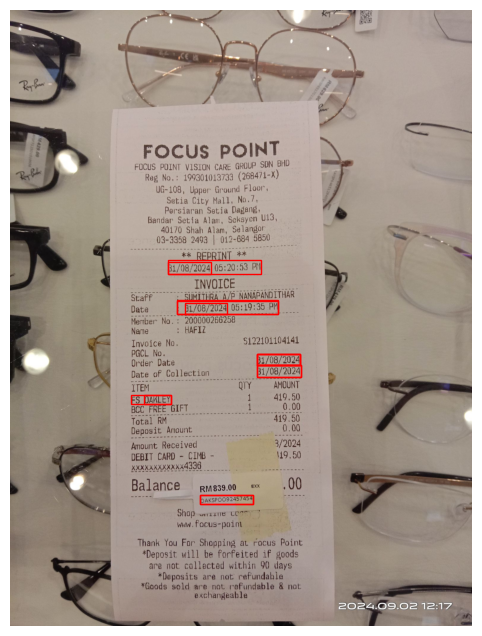

In [1109]:
display_blocks_on_image(
    file_path, 
    result['receipt_date'] + result['receipt_number'] + result['brand_model'] + result['brand'],
    True
    )

## Run test on complete dataset

In [797]:
updated_data = pd.read_csv(updated_data_source)
updated_data = updated_data#.head(10)
# data = data[data['file_name'] == file_name]
# updated_data = updated_data[updated_data['file_name'] == file_name]
updated_data

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1,Approved,Printed,NaN,Yes,mmexport1725432543089.png,0.048774
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144621.jpg,0.265176
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144549.jpg,0.268750
3,961570,0.0,2024-09-04,Coach,104751,8371,Receipt/2024/jpeg_20240904_144505.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144505.jpg,0.343383
4,961569,629.0,2024-08-31,Ray-Ban,OR004770,ORB2140F,Receipt/2024/mmexport1725431557988.png,1,Approved,Printed,NaN,Yes,mmexport1725431557988.png,0.057045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,959556,0.0,2024-08-31,Coach,17907967,hc7133-94038d-57,Receipt/2024/kya4nbhaik.jpg,1,Approved,Printed,NaN,Yes,kya4nbhaik.jpg,3.669875
1996,959555,0.0,2024-08-31,Ray-Ban,S115701105503,3825,Receipt/2024/jpeg_20240902_105739.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105739.jpg,0.610140
1997,959554,0.0,2024-08-31,Ray-Ban,17907966,4391d-645087-56,Receipt/2024/cmahjoywpx.jpg,1,Approved,Printed,NaN,Yes,cmahjoywpx.jpg,3.597690
1998,959553,0.0,2024-08-30,Coach,S115701105486,8395,Receipt/2024/jpeg_20240902_105620.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105620.jpg,0.690908


In [798]:
processed_data_source = os.path.join(download_folder, 'csvs', 'processed_data.csv')
os.makedirs(os.path.dirname(processed_data_source), exist_ok=True)

processed_responses = []
for index, row in updated_data.iterrows():
    t_file_name = row['file_name'] 
    print(f'********* processing = {index} - {t_file_name}')
    t_result_dict = {}
    response = fetch_ocr_data(t_file_name, os.path.join(download_folder, 'images',
                                                        
                                                        
                                                         t_file_name))
    selected_columns = ['date_of_receipt', 'receipt_number', 'brand', 'brand_model']
    filtered_data = updated_data[updated_data['file_name'] == t_file_name]
    result_dict = filtered_data[selected_columns].iloc[0].to_dict()
    print(f'@@@@@@ result = {result_dict}')
    # result = find_blocks(result_dict, response)
    result = validate_inputs(result_dict, response, False)
    for key in result.keys():
        texts = []
        for block in result[key]:
            texts.append(block.text)
        t_result_dict[f'm_{key}'] =  texts
        # print(f'result_dict = {t_result_dict}')
    t_result_dict['id'] = row['id']
    processed_responses.append(t_result_dict)
updated_data['processed_data'] = processed_responses
updated_data.to_csv(processed_data_source, index=False)
updated_data

********* processing = 0 - mmexport1725432543089.png
<<<<<< fetch_ocr_data = dryice_test/images/mmexport1725432543089.png
<<<< sqlite: db_file = dryice_test/db/textract_responses.db
Found existing response in SQLite: mmexport1725432543089.png
@@@@@@ result = {'date_of_receipt': '2024-08-29', 'receipt_number': 'OR000811', 'brand': 'Armani Exchange', 'brand_model': 'OAX1064'}
user_input_receipt_number = OR000811
********* processing = 1 - jpeg_20240904_144621.jpg
<<<<<< fetch_ocr_data = dryice_test/images/jpeg_20240904_144621.jpg
<<<< sqlite: db_file = dryice_test/db/textract_responses.db
Found existing response in SQLite: jpeg_20240904_144621.jpg
@@@@@@ result = {'date_of_receipt': '2024-08-23', 'receipt_number': '106700', 'brand': 'Coach', 'brand_model': '6215D'}
user_input_receipt_number = 106700
********* processing = 2 - jpeg_20240904_144549.jpg
<<<<<< fetch_ocr_data = dryice_test/images/jpeg_20240904_144549.jpg
<<<< sqlite: db_file = dryice_test/db/textract_responses.db
Found exist

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB,processed_data
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1,Approved,Printed,NaN,Yes,mmexport1725432543089.png,0.048774,"{'m_receipt_date': ['29/08/2024', '29/08/2024'..."
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144621.jpg,0.265176,{'m_receipt_date': [': 23/08/2024 03:58:58 PM'...
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144549.jpg,0.268750,{'m_receipt_date': [': 15/08/2024 11:37:23 AM'...
3,961570,0.0,2024-09-04,Coach,104751,8371,Receipt/2024/jpeg_20240904_144505.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144505.jpg,0.343383,{'m_receipt_date': [': 04/09/2024 01:43:17 PM'...
4,961569,629.0,2024-08-31,Ray-Ban,OR004770,ORB2140F,Receipt/2024/mmexport1725431557988.png,1,Approved,Printed,NaN,Yes,mmexport1725431557988.png,0.057045,"{'m_receipt_date': ['31/08/2024', '31/08/2024'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,959556,0.0,2024-08-31,Coach,17907967,hc7133-94038d-57,Receipt/2024/kya4nbhaik.jpg,1,Approved,Printed,NaN,Yes,kya4nbhaik.jpg,3.669875,"{'m_receipt_date': [': 31/08/2024', '31/08/202..."
1996,959555,0.0,2024-08-31,Ray-Ban,S115701105503,3825,Receipt/2024/jpeg_20240902_105739.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105739.jpg,0.610140,"{'m_receipt_date': ['31/08/2024 07:01:39 PM', ..."
1997,959554,0.0,2024-08-31,Ray-Ban,17907966,4391d-645087-56,Receipt/2024/cmahjoywpx.jpg,1,Approved,Printed,NaN,Yes,cmahjoywpx.jpg,3.597690,"{'m_receipt_date': [': 31/08/2024', '31/08/202..."
1998,959553,0.0,2024-08-30,Coach,S115701105486,8395,Receipt/2024/jpeg_20240902_105620.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105620.jpg,0.690908,"{'m_receipt_date': ['30/08/2024 05:23:12 PM', ..."


In [799]:
processed_df = pd.DataFrame(processed_responses)
processed_df

,m_receipt_date,m_receipt_number,m_brand_model,m_brand,id
0,"[29/08/2024, 29/08/2024, Created on 29/08/2024...","[OR000811, OR000811]",[],[1 ARMANI EXCHANGE],961573
1,"[: 23/08/2024 03:58:58 PM, 23/08/2024, 23/08/2...","[S118501106700, S118501106700]",[],"[FF COACH, COACH]",961572
2,"[: 15/08/2024 11:37:23 AM, 15/08/2024, 15/08/2...","[S118501106570, S118501106570]","[SG 9245, 9245]","[FS OAKLEY, OAKLEY]",961571
3,"[: 04/09/2024 01:43:17 PM, 04/09/2024, 04/09/2...","[S122001104751, S122001104751]","[COASP8371U157458754, COASP8371U157458754]","[FS COACH, COACH]",961570
4,"[31/08/2024, 31/08/2024, Created on 31/08/2024...","[OR004770, OR004770]",[],"[1 RAYBAN, RAYBAN]",961569
...,...,...,...,...,...
1995,"[: 31/08/2024, 31/08/2024, 31/08/2024, 31/08/2...","[: 17907967, 17907967]","[SCOA-HC7133-94038D-57, SCOA-HC7133-94038D-57]","[COACH, COACH CASING, COACH, COACH]",959556
1996,"[31/08/2024 07:01:39 PM, : 31/08/2024 07:01:10...","[S115701105503, S115701105503]","[RAYSP382510015862, RAYSP382510015862]",[FS RAY BAN],959555
1997,"[: 31/08/2024, 31/08/2024, 31/08/2024, 31/08/2...","[: 17907966, 17907966]",[],"[RAYBAN, RAYBAN CASING, RAYBAN, RAYBAN]",959554
1998,"[30/08/2024 05:23:12 PM, : 30/08/2024 04:28:37...","[S115701105486, S115701105486]","[COASP8395F158139056, COASP8395F158139056]","[FS COACH, COACH]",959553


In [800]:
merged_datasource_path = os.path.join(download_folder, 'csvs', 'merged.csv')
os.makedirs(os.path.dirname(processed_data_source), exist_ok=True)

merged_data = pd.merge(updated_data, processed_df, on='id', how='inner') #pd.concat([, processed_df])
merged_data.to_csv(merged_datasource_path)
merged_data

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB,processed_data,m_receipt_date,m_receipt_number,m_brand_model,m_brand
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1,Approved,Printed,NaN,Yes,mmexport1725432543089.png,0.048774,"{'m_receipt_date': ['29/08/2024', '29/08/2024'...","[29/08/2024, 29/08/2024, Created on 29/08/2024...","[OR000811, OR000811]",[],[1 ARMANI EXCHANGE]
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144621.jpg,0.265176,{'m_receipt_date': [': 23/08/2024 03:58:58 PM'...,"[: 23/08/2024 03:58:58 PM, 23/08/2024, 23/08/2...","[S118501106700, S118501106700]",[],"[FF COACH, COACH]"
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144549.jpg,0.268750,{'m_receipt_date': [': 15/08/2024 11:37:23 AM'...,"[: 15/08/2024 11:37:23 AM, 15/08/2024, 15/08/2...","[S118501106570, S118501106570]","[SG 9245, 9245]","[FS OAKLEY, OAKLEY]"
3,961570,0.0,2024-09-04,Coach,104751,8371,Receipt/2024/jpeg_20240904_144505.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144505.jpg,0.343383,{'m_receipt_date': [': 04/09/2024 01:43:17 PM'...,"[: 04/09/2024 01:43:17 PM, 04/09/2024, 04/09/2...","[S122001104751, S122001104751]","[COASP8371U157458754, COASP8371U157458754]","[FS COACH, COACH]"
4,961569,629.0,2024-08-31,Ray-Ban,OR004770,ORB2140F,Receipt/2024/mmexport1725431557988.png,1,Approved,Printed,NaN,Yes,mmexport1725431557988.png,0.057045,"{'m_receipt_date': ['31/08/2024', '31/08/2024'...","[31/08/2024, 31/08/2024, Created on 31/08/2024...","[OR004770, OR004770]",[],"[1 RAYBAN, RAYBAN]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,959556,0.0,2024-08-31,Coach,17907967,hc7133-94038d-57,Receipt/2024/kya4nbhaik.jpg,1,Approved,Printed,NaN,Yes,kya4nbhaik.jpg,3.669875,"{'m_receipt_date': [': 31/08/2024', '31/08/202...","[: 31/08/2024, 31/08/2024, 31/08/2024, 31/08/2...","[: 17907967, 17907967]","[SCOA-HC7133-94038D-57, SCOA-HC7133-94038D-57]","[COACH, COACH CASING, COACH, COACH]"
1996,959555,0.0,2024-08-31,Ray-Ban,S115701105503,3825,Receipt/2024/jpeg_20240902_105739.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105739.jpg,0.610140,"{'m_receipt_date': ['31/08/2024 07:01:39 PM', ...","[31/08/2024 07:01:39 PM, : 31/08/2024 07:01:10...","[S115701105503, S115701105503]","[RAYSP382510015862, RAYSP382510015862]",[FS RAY BAN]
1997,959554,0.0,2024-08-31,Ray-Ban,17907966,4391d-645087-56,Receipt/2024/cmahjoywpx.jpg,1,Approved,Printed,NaN,Yes,cmahjoywpx.jpg,3.597690,"{'m_receipt_date': [': 31/08/2024', '31/08/202...","[: 31/08/2024, 31/08/2024, 31/08/2024, 31/08/2...","[: 17907966, 17907966]",[],"[RAYBAN, RAYBAN CASING, RAYBAN, RAYBAN]"
1998,959553,0.0,2024-08-30,Coach,S115701105486,8395,Receipt/2024/jpeg_20240902_105620.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105620.jpg,0.690908,"{'m_receipt_date': ['30/08/2024 05:23:12 PM', ...","[30/08/2024 05:23:12 PM, : 30/08/2024 04:28:37...","[S115701105486, S115701105486]","[COASP8395F158139056, COASP8395F158139056]","[FS COACH, COACH]"


In [801]:
subset_df = merged_data[['status_label','m_receipt_date', 'm_receipt_number', 'm_brand', 'm_brand_model']]
subset_df

,status_label,m_receipt_date,m_receipt_number,m_brand,m_brand_model
0,Approved,"[29/08/2024, 29/08/2024, Created on 29/08/2024...","[OR000811, OR000811]",[1 ARMANI EXCHANGE],[]
1,Approved,"[: 23/08/2024 03:58:58 PM, 23/08/2024, 23/08/2...","[S118501106700, S118501106700]","[FF COACH, COACH]",[]
2,Approved,"[: 15/08/2024 11:37:23 AM, 15/08/2024, 15/08/2...","[S118501106570, S118501106570]","[FS OAKLEY, OAKLEY]","[SG 9245, 9245]"
3,Approved,"[: 04/09/2024 01:43:17 PM, 04/09/2024, 04/09/2...","[S122001104751, S122001104751]","[FS COACH, COACH]","[COASP8371U157458754, COASP8371U157458754]"
4,Approved,"[31/08/2024, 31/08/2024, Created on 31/08/2024...","[OR004770, OR004770]","[1 RAYBAN, RAYBAN]",[]
...,...,...,...,...,...
1995,Approved,"[: 31/08/2024, 31/08/2024, 31/08/2024, 31/08/2...","[: 17907967, 17907967]","[COACH, COACH CASING, COACH, COACH]","[SCOA-HC7133-94038D-57, SCOA-HC7133-94038D-57]"
1996,Approved,"[31/08/2024 07:01:39 PM, : 31/08/2024 07:01:10...","[S115701105503, S115701105503]",[FS RAY BAN],"[RAYSP382510015862, RAYSP382510015862]"
1997,Approved,"[: 31/08/2024, 31/08/2024, 31/08/2024, 31/08/2...","[: 17907966, 17907966]","[RAYBAN, RAYBAN CASING, RAYBAN, RAYBAN]",[]
1998,Approved,"[30/08/2024 05:23:12 PM, : 30/08/2024 04:28:37...","[S115701105486, S115701105486]","[FS COACH, COACH]","[COASP8395F158139056, COASP8395F158139056]"


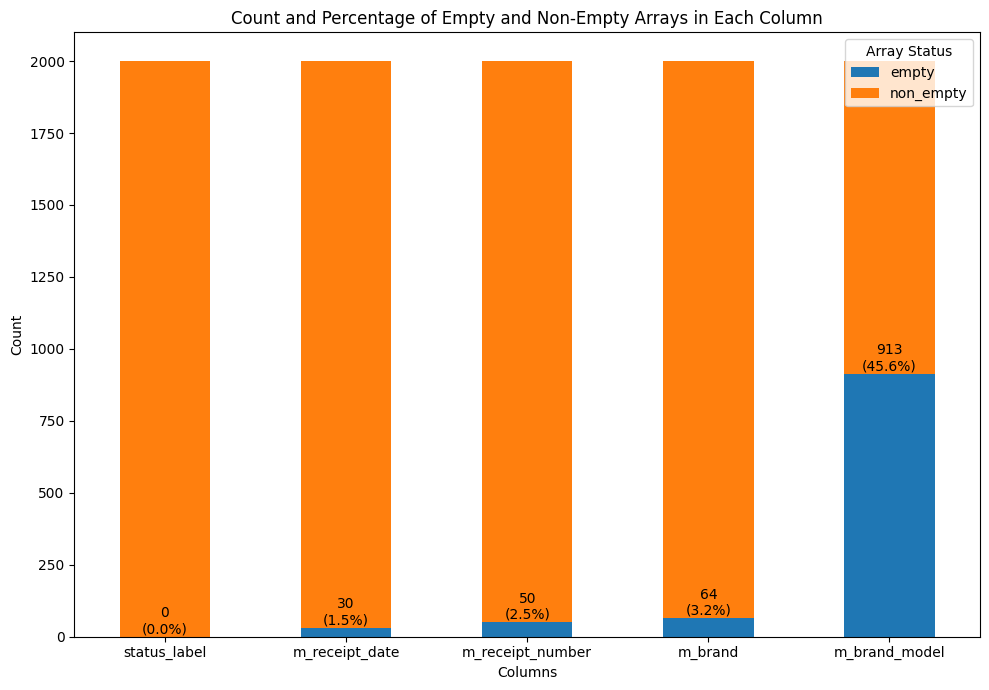

In [773]:
# Count empty and non-empty arrays
def count_empty_non_empty(df):
    counts = {'empty': {}, 'non_empty': {}}
    for column in df.columns:
        empty_count = df[column].apply(lambda x: len(x) == 0).sum()
        non_empty_count = len(df) - empty_count
        counts['empty'][column] = empty_count
        counts['non_empty'][column] = non_empty_count
    return counts

counts = count_empty_non_empty(subset_df)

# Convert counts to DataFrame
counts_df = pd.DataFrame(counts)

# Plotting the stacked bar chart
ax = counts_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Count and Percentage of Empty and Non-Empty Arrays in Each Column')
plt.xticks(rotation=0)
plt.legend(title='Array Status', loc='upper right')

# Calculate and annotate percentages
total_records = len(subset_df)
for idx, column in enumerate(subset_df.columns):
    empty_count = counts['empty'][column]
    empty_percentage = (empty_count / total_records) * 100
    ax.annotate(f'{empty_count}\n({empty_percentage:.1f}%)',
                xy=(idx, empty_count + 1),
                ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

/var/folders/2d/pvchbzgd1s7c2jy60p9lpbn00000gn/T/ipykernel_18563/796881345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['ai_approver_status'] = subset_df.apply(


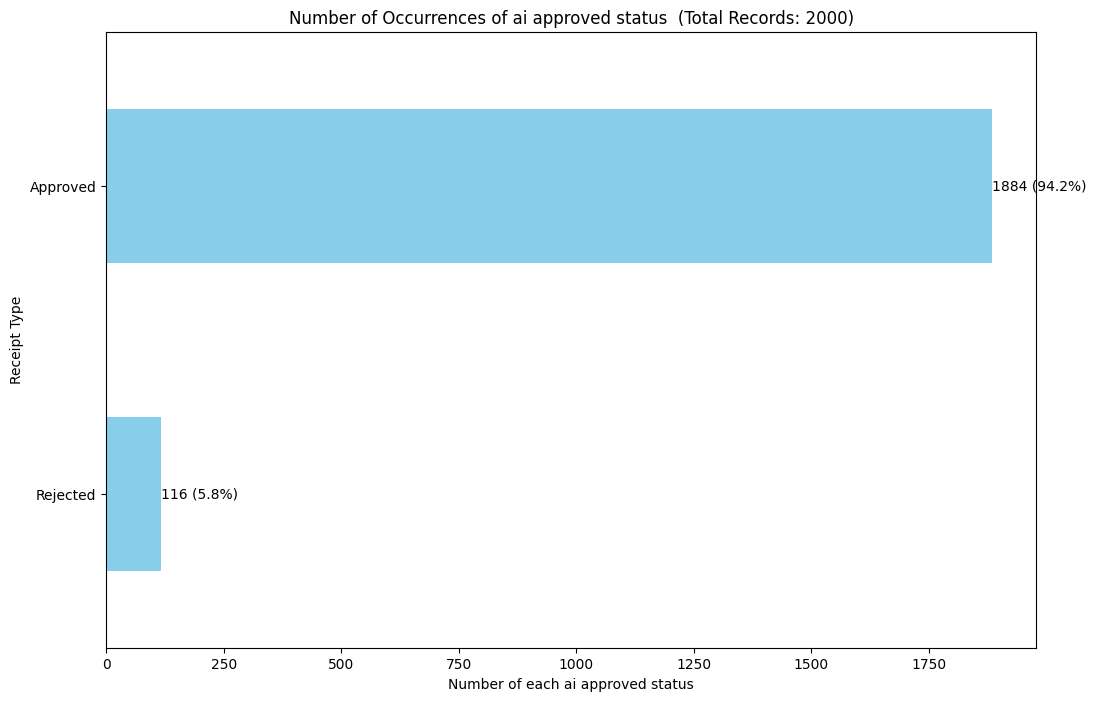

In [802]:
subset_df['ai_approver_status'] = subset_df.apply(
    lambda row: 'Approved' if row['m_receipt_date'] and row['m_receipt_number'] and row['m_brand'] else 'Rejected',
    axis=1
)

subset_df

# Count occurrences of each receipt_type
receipt_type_counts = subset_df['ai_approver_status'].value_counts()

# Calculate the total number of records
total_records = len(subset_df)

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = receipt_type_counts.plot(kind='barh', color='skyblue')

# Annotate the bars with the count and percentage values
for bar in bars.patches:
    width = bar.get_width()
    percentage = (width / total_records) * 100
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width)} ({percentage:.1f}%)', 
             va='center', ha='left', fontsize=10, color='black')

# Set the title with total number of records
plt.xlabel('Number of each ai approved status')
plt.ylabel('Receipt Type')
plt.title(f'Number of Occurrences of ai approved status  (Total Records: {total_records})')
plt.gca().invert_yaxis()  # Optional: Invert y-axis to show the most frequent brand at the top
plt.show()

In [803]:
# Find the number of records where 'ai_approver_status' matches 'status_label'
matching_records = subset_df[subset_df['ai_approver_status'] == subset_df['status_label']]

# Get the count of matching records
matching_count = len(matching_records)
percentage_matching = (matching_count / total_records) * 100

# Display the result
print(f"Percentage of records where 'ai_approver_status' matches 'status_label': {percentage_matching:.2f}% i.e {matching_count} receipts")

Percentage of records where 'ai_approver_status' matches 'status_label': 94.35% i.e 1887 receipts


In [804]:
data_with_ai_labels = merged_data
data_with_ai_labels['ai_approver_status'] = data_with_ai_labels.apply(
    lambda row: 'Approved' if row['m_receipt_date'] and row['m_receipt_number'] and row['m_brand'] else 'Rejected',
    axis=1
)
data_with_ai_labels
data_with_ai_labels_path = os.path.join(download_folder, 'csvs', 'data_with_ai_labels_new_date.csv')
data_with_ai_labels.to_csv(data_with_ai_labels_path)

## Introspect 

In [69]:
# merged_data = pd.read_csv(os.path.join(download_folder, 'csvs', 'merged.csv'))
# subset_df = merged_data[['status_label','m_receipt_date', 'm_receipt_number', 'm_brand', 'm_brand_model']]
# subset_df['ai_approver_status'] = subset_df.apply(
#     lambda row: 'Approved' if row['m_receipt_date'] and row['m_receipt_number'] and row['m_brand'] else 'Rejected',
#     axis=1
# )

approved = subset_df[subset_df['status_label'] == 'Approved']
rejected = subset_df[subset_df['status_label'] == 'Rejected']
ai_approved = subset_df[subset_df['ai_approver_status'] == 'Approved']
ai_rejected = subset_df[subset_df['ai_approver_status'] == 'Rejected']
print(f'total = {len(subset_df)} | approved : {len(approved)} | rejected : {len(rejected)} | ai_approved : {len(ai_approved)} | ai_rejected : {len(ai_rejected)}')
# subset_df
filtered_df = subset_df[subset_df['status_label'] != subset_df['ai_approver_status']]
filtered_df

total = 2000 | approved : 1941 | rejected : 59 | ai_approved : 1842 | ai_rejected : 158


,status_label,m_receipt_date,m_receipt_number,m_brand,m_brand_model,ai_approver_status
28,Approved,"[07/06/2024, 07/06/2024, 07/06/2024, 07/06/202...",[],"[FF COACH, COACH]",[],Rejected
48,Approved,[],[],[],[],Rejected
94,Rejected,[28/08/2024],"[: 21604377, 21604377]","[RAYBAN, RAYBAN CASING, RAYBAN, RAYBAN]",[],Approved
95,Rejected,[28/08/2024],"[: 21604377, 21604377]","[OAKLEY CASING, OAKLEY]","[SOK-009417-03-59, SOK-009417-03-59]",Approved
98,Approved,"[03/08/2024, 03/08/2024]",[],"[OAKLEY CASING, OAKLEY]","[FOK-3217-1557, FOK-3217-1557]",Rejected
...,...,...,...,...,...,...
1933,Approved,"[31/08/2024 05:20:53 PM, 31/08/2024, 31/08/202...",[],"[FS OAKLEY, OAKLEY]","[OAKSPOO92457454, OAKSPOO92457454]",Rejected
1934,Approved,[],"[Sales Receipt #165224, #165224]","[RAY BAN - BEST BUY, Serial # RAYBAN 64182983,...","[RB5403D 2001, RB5403D]",Rejected
1935,Approved,[],"[Sales Receipt #165224, #165224]","[RAY BAN - BEST BUY, Serial # RAYBAN 64182983,...","[RB5403D 2001, RB5403D]",Rejected
1944,Approved,[],"[Sales Receipt #165168, 165168, #165168, 165168]","[OAKLEY SGL, OAKLEY]","[009102, 009102]",Rejected


In [68]:
data_approved_but_ai_rejected = subset_df[(subset_df['status_label'] == 'Approved') & (subset_df['ai_approver_status'] == 'Rejected')]
data_approved_but_ai_rejected

,status_label,m_receipt_date,m_receipt_number,m_brand,m_brand_model,ai_approver_status
28,Approved,"[07/06/2024, 07/06/2024, 07/06/2024, 07/06/202...",[],"[FF COACH, COACH]",[],Rejected
48,Approved,[],[],[],[],Rejected
98,Approved,"[03/08/2024, 03/08/2024]",[],"[OAKLEY CASING, OAKLEY]","[FOK-3217-1557, FOK-3217-1557]",Rejected
145,Approved,[],"[: 21604267, 21604267]","[ARMANI EXCHANGE FRAME, ARMANI EXCHANGE CASING]","[FAX-1019-6063-54, FAX-1019-6063-54]",Rejected
148,Approved,"[03-Sep-2024, 03-Sep-2024, 03/Sep/2024, 3., 03...",[],"[OAKLEY SUNGLASS, OAKLEY]","[OAK-924563-FROG, OAK-924563-FROG]",Rejected
...,...,...,...,...,...,...
1933,Approved,"[31/08/2024 05:20:53 PM, 31/08/2024, 31/08/202...",[],"[FS OAKLEY, OAKLEY]","[OAKSPOO92457454, OAKSPOO92457454]",Rejected
1934,Approved,[],"[Sales Receipt #165224, #165224]","[RAY BAN - BEST BUY, Serial # RAYBAN 64182983,...","[RB5403D 2001, RB5403D]",Rejected
1935,Approved,[],"[Sales Receipt #165224, #165224]","[RAY BAN - BEST BUY, Serial # RAYBAN 64182983,...","[RB5403D 2001, RB5403D]",Rejected
1944,Approved,[],"[Sales Receipt #165168, 165168, #165168, 165168]","[OAKLEY SGL, OAKLEY]","[009102, 009102]",Rejected


In [74]:
ai_status_df = merged_data
ai_status_df['ai_approver_status'] = ai_status_df.apply(
    lambda row: 'Approved' if row['m_receipt_date'] and row['m_receipt_number'] and row['m_brand'] else 'Rejected',
    axis=1
)
ai_status_df.to_csv(os.path.join(download_folder, 'csvs', 'merged+ai_labels.csv'))
ai_status_df

,id,amount,date_of_receipt,brand,receipt_number,brand_model,img,status,status_label,receipt_type,classifier_exception,file_exists,file_name,file_size_MB,processed_data,m_receipt_date,m_receipt_number,m_brand_model,m_brand,ai_approver_status
0,961573,394.0,2024-08-29,Armani Exchange,OR000811,OAX1064,Receipt/2024/mmexport1725432543089.png,1,Approved,Printed,NaN,Yes,mmexport1725432543089.png,0.048774,"{'m_receipt_date': ['29/08/2024', '29/08/2024'...","[29/08/2024, 29/08/2024, 29/08/2024, 29/08/202...","[OR000811, OR000811]",[],[1 ARMANI EXCHANGE],Approved
1,961572,403.0,2024-08-23,Coach,106700,6215D,Receipt/2024/jpeg_20240904_144621.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144621.jpg,0.265176,"{'m_receipt_date': ['23/08/2024', '23/08/2024'...","[23/08/2024, 23/08/2024, 23/08/2024, 23/08/202...","[S118501106700, S118501106700]",[],"[FF COACH, COACH]",Approved
2,961571,420.0,2024-08-15,Oakley,106570,9245,Receipt/2024/jpeg_20240904_144549.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144549.jpg,0.268750,"{'m_receipt_date': ['15/08/2024', '15/08/2024'...","[15/08/2024, 15/08/2024, 15/08/2024, 15/08/202...","[S118501106570, S118501106570]","[SG 9245, 9245]","[FS OAKLEY, OAKLEY]",Approved
3,961570,0.0,2024-09-04,Coach,104751,8371,Receipt/2024/jpeg_20240904_144505.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240904_144505.jpg,0.343383,"{'m_receipt_date': ['04/09/2024', '04/09/2024'...","[04/09/2024, 04/09/2024, 04/09/2024, 04/09/202...","[S122001104751, S122001104751]","[COASP8371U157458754, COASP8371U157458754]","[FS COACH, COACH]",Approved
4,961569,629.0,2024-08-31,Ray-Ban,OR004770,ORB2140F,Receipt/2024/mmexport1725431557988.png,1,Approved,Printed,NaN,Yes,mmexport1725431557988.png,0.057045,"{'m_receipt_date': ['31/08/2024', '31/08/2024'...","[31/08/2024, 31/08/2024, 31/08/2024, 31/08/202...","[OR004770, OR004770]",[],"[1 RAYBAN, RAYBAN]",Approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,959556,0.0,2024-08-31,Coach,17907967,hc7133-94038d-57,Receipt/2024/kya4nbhaik.jpg,1,Approved,Printed,NaN,Yes,kya4nbhaik.jpg,3.669875,"{'m_receipt_date': ['31/08/2024', '31/08/2024'...","[31/08/2024, 31/08/2024, 31/08/2024, 31/08/2024]","[: 17907967, 17907967]","[SCOA-HC7133-94038D-57, SCOA-HC7133-94038D-57]","[COACH, COACH CASING, COACH, COACH]",Approved
1996,959555,0.0,2024-08-31,Ray-Ban,S115701105503,3825,Receipt/2024/jpeg_20240902_105739.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105739.jpg,0.610140,"{'m_receipt_date': ['31/08/2024 07:01:39 PM', ...","[31/08/2024 07:01:39 PM, 31/08/2024, 31/08/202...","[S115701105503, S115701105503]","[RAYSP382510015862, RAYSP382510015862]",[FS RAY BAN],Approved
1997,959554,0.0,2024-08-31,Ray-Ban,17907966,4391d-645087-56,Receipt/2024/cmahjoywpx.jpg,1,Approved,Printed,NaN,Yes,cmahjoywpx.jpg,3.597690,"{'m_receipt_date': ['31/08/2024', '31/08/2024'...","[31/08/2024, 31/08/2024, 31/08/2024, 31/08/2024]","[: 17907966, 17907966]",[],"[RAYBAN, RAYBAN CASING, RAYBAN, RAYBAN]",Approved
1998,959553,0.0,2024-08-30,Coach,S115701105486,8395,Receipt/2024/jpeg_20240902_105620.jpg,1,Approved,Printed,NaN,Yes,jpeg_20240902_105620.jpg,0.690908,"{'m_receipt_date': ['30/08/2024 05:23:12 PM', ...","[30/08/2024 05:23:12 PM, 30/08/2024, 30/08/202...","[S115701105486, S115701105486]","[COASP8395F158139056, COASP8395F158139056]","[FS COACH, COACH]",Approved


In [73]:
approved = ai_status_df[ai_status_df['status_label'] == 'Approved']
rejected = ai_status_df[ai_status_df['status_label'] == 'Rejected']
ai_approved = ai_status_df[ai_status_df['ai_approver_status'] == 'Approved']
ai_rejected = ai_status_df[ai_status_df['ai_approver_status'] == 'Rejected']
print(f'total = {len(ai_status_df)} | approved : {len(approved)} | rejected : {len(rejected)} | ai_approved : {len(ai_approved)} | ai_rejected : {len(ai_rejected)}')


total = 2000 | approved : 1941 | rejected : 59 | ai_approved : 1842 | ai_rejected : 158


# test methods

In [729]:

# Example usage
input_date = "2024-08-31"
date_variations = generate_date_formats(input_date)
for variation in date_variations:
    print(variation)

08 31 2024
08 31 24
08 31,2024
08 31,24
08 31-2024
08 31-24
08 31.2024
08 31.24
08 31/2024
08 31/24
08,31 2024
08,31 24
08,31,2024
08,31,24
08,31-2024
08,31-24
08,31.2024
08,31.24
08,31/2024
08,31/24
08-31 2024
08-31 24
08-31,2024
08-31,24
08-31-2024
08-31-24
08-31.2024
08-31.24
08-31/2024
08-31/24
08.31 2024
08.31 24
08.31,2024
08.31,24
08.31-2024
08.31-24
08.31.2024
08.31.24
08.31/2024
08.31/24
08/31 2024
08/31 24
08/31,2024
08/31,24
08/31-2024
08/31-24
08/31.2024
08/31.24
08/31/2024
08/31/24
2024 08 31
2024 08,31
2024 08-31
2024 08.31
2024 08/31
2024 8 31
2024 8,31
2024 8-31
2024 8.31
2024 8/31
2024 Aug 31
2024 Aug,31
2024 Aug-31
2024 Aug.31
2024 Aug/31
2024 August 31
2024 August,31
2024 August-31
2024 August.31
2024 August/31
2024,08 31
2024,08,31
2024,08-31
2024,08.31
2024,08/31
2024,8 31
2024,8,31
2024,8-31
2024,8.31
2024,8/31
2024,Aug 31
2024,Aug,31
2024,Aug-31
2024,Aug.31
2024,Aug/31
2024,August 31
2024,August,31
2024,August-31
2024,August.31
2024,August/31
2024-08 31
2024-08,3